In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import pandas as pd
from sklearn.metrics import confusion_matrix

### Load data

In [3]:
dname = os.getcwd() + '/../../data/'

In [4]:
BLOC_TYPE = np.load(dname + 'BLOC_TYPE.npy', allow_pickle=True)
CORRECT_BLOC = np.load(dname + 'CORRECT_BLOC.npy')
RT_BLOC = np.load(dname + 'RT_BLOC.npy')
BLOC_CENTER_TRIAL = np.load(dname + 'BLOC_CENTER_TRIAL.npy', allow_pickle=True)
BLOC_STARTING_TRIAL = np.load(dname + 'BLOC_STARTING_TRIAL.npy', allow_pickle=True)
CORRECT_CATEGORY_BLOC = np.load(dname + 'CORRECT_CATEGORY_BLOC.npy', allow_pickle=True)
RESPONSE_CATEGORY_BLOC = np.load(dname + 'RESPONSE_CATEGORY_BLOC.npy', allow_pickle=True)
TRIAL_TYPE = np.load(dname + 'TRIAL_TYPE.npy')
DIMS = np.load(dname + 'DIMS.npy', allow_pickle=True)
MODALITY = np.load(dname + 'MODALITY.npy', allow_pickle=True)

In [5]:
CORRECT_BLOC.shape

(97, 14, 30)

In [6]:
n_sujs, n_blocs, n_trials = CORRECT_BLOC.shape
n_trials_per_suj = n_blocs * n_trials

In [7]:
modalities = np.array(['audio', 'visual', 'spatial'])
modalities_plot = np.array(['Auditory', 'Visual', 'Spatial (visual)'])
n_modalities = np.size(modalities)

### Plotting parameters

In [8]:
cmap = matplotlib.cm.get_cmap('Set1')
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

In [9]:
bloc_type_colors = {
    'training': cmap(norm(0)),
    'generalization': cmap(norm(.2))
}
bloc_type_cmaps = {
    'training': matplotlib.cm.get_cmap('Reds'),
    'generalization': matplotlib.cm.get_cmap('Blues')
}
win_size = 8

# Figure 1 - Performances

### Individual data pooled by trial type

In [10]:
TRIAL_TYPE.shape

(97, 14, 30)

In [11]:
CORRECT_BLOC.shape

(97, 14, 30)

In [12]:
# Compute rolling average per suj per bloc per trial type
CORRECT_BLOC_GEN = np.full((n_sujs, n_blocs, 2, n_trials), np.nan)
for i in range(n_sujs):
    for j in range(n_blocs):
        for k, trial_type in enumerate(['training', 'generalization']):
            
            # Select data 
            idx = TRIAL_TYPE[i, j] == 64 if trial_type == 'training' else TRIAL_TYPE[i, j] != 64
            data = CORRECT_BLOC[i, j][idx]
            idx_data = np.logical_not(np.isnan(data))
            
            # Escape if all data is nan
            if np.all(np.isnan(data)): continue
            
            # Store accuracy 
            CORRECT_BLOC_GEN[i, j, k, :idx_data.sum()] = data[idx_data]

In [13]:
CORRECT_BLOC_GEN.shape

(97, 14, 2, 30)

/tmp/ipykernel_6777/2836957326.py:14: RuntimeWarning: Mean of empty slice
  m_sujs = np.nanmean(CORRECT_BLOC_GEN[idx, :, 0], axis=-1)
/tmp/ipykernel_6777/2836957326.py:14: RuntimeWarning: Mean of empty slice
  m_sujs = np.nanmean(CORRECT_BLOC_GEN[idx, :, 0], axis=-1)


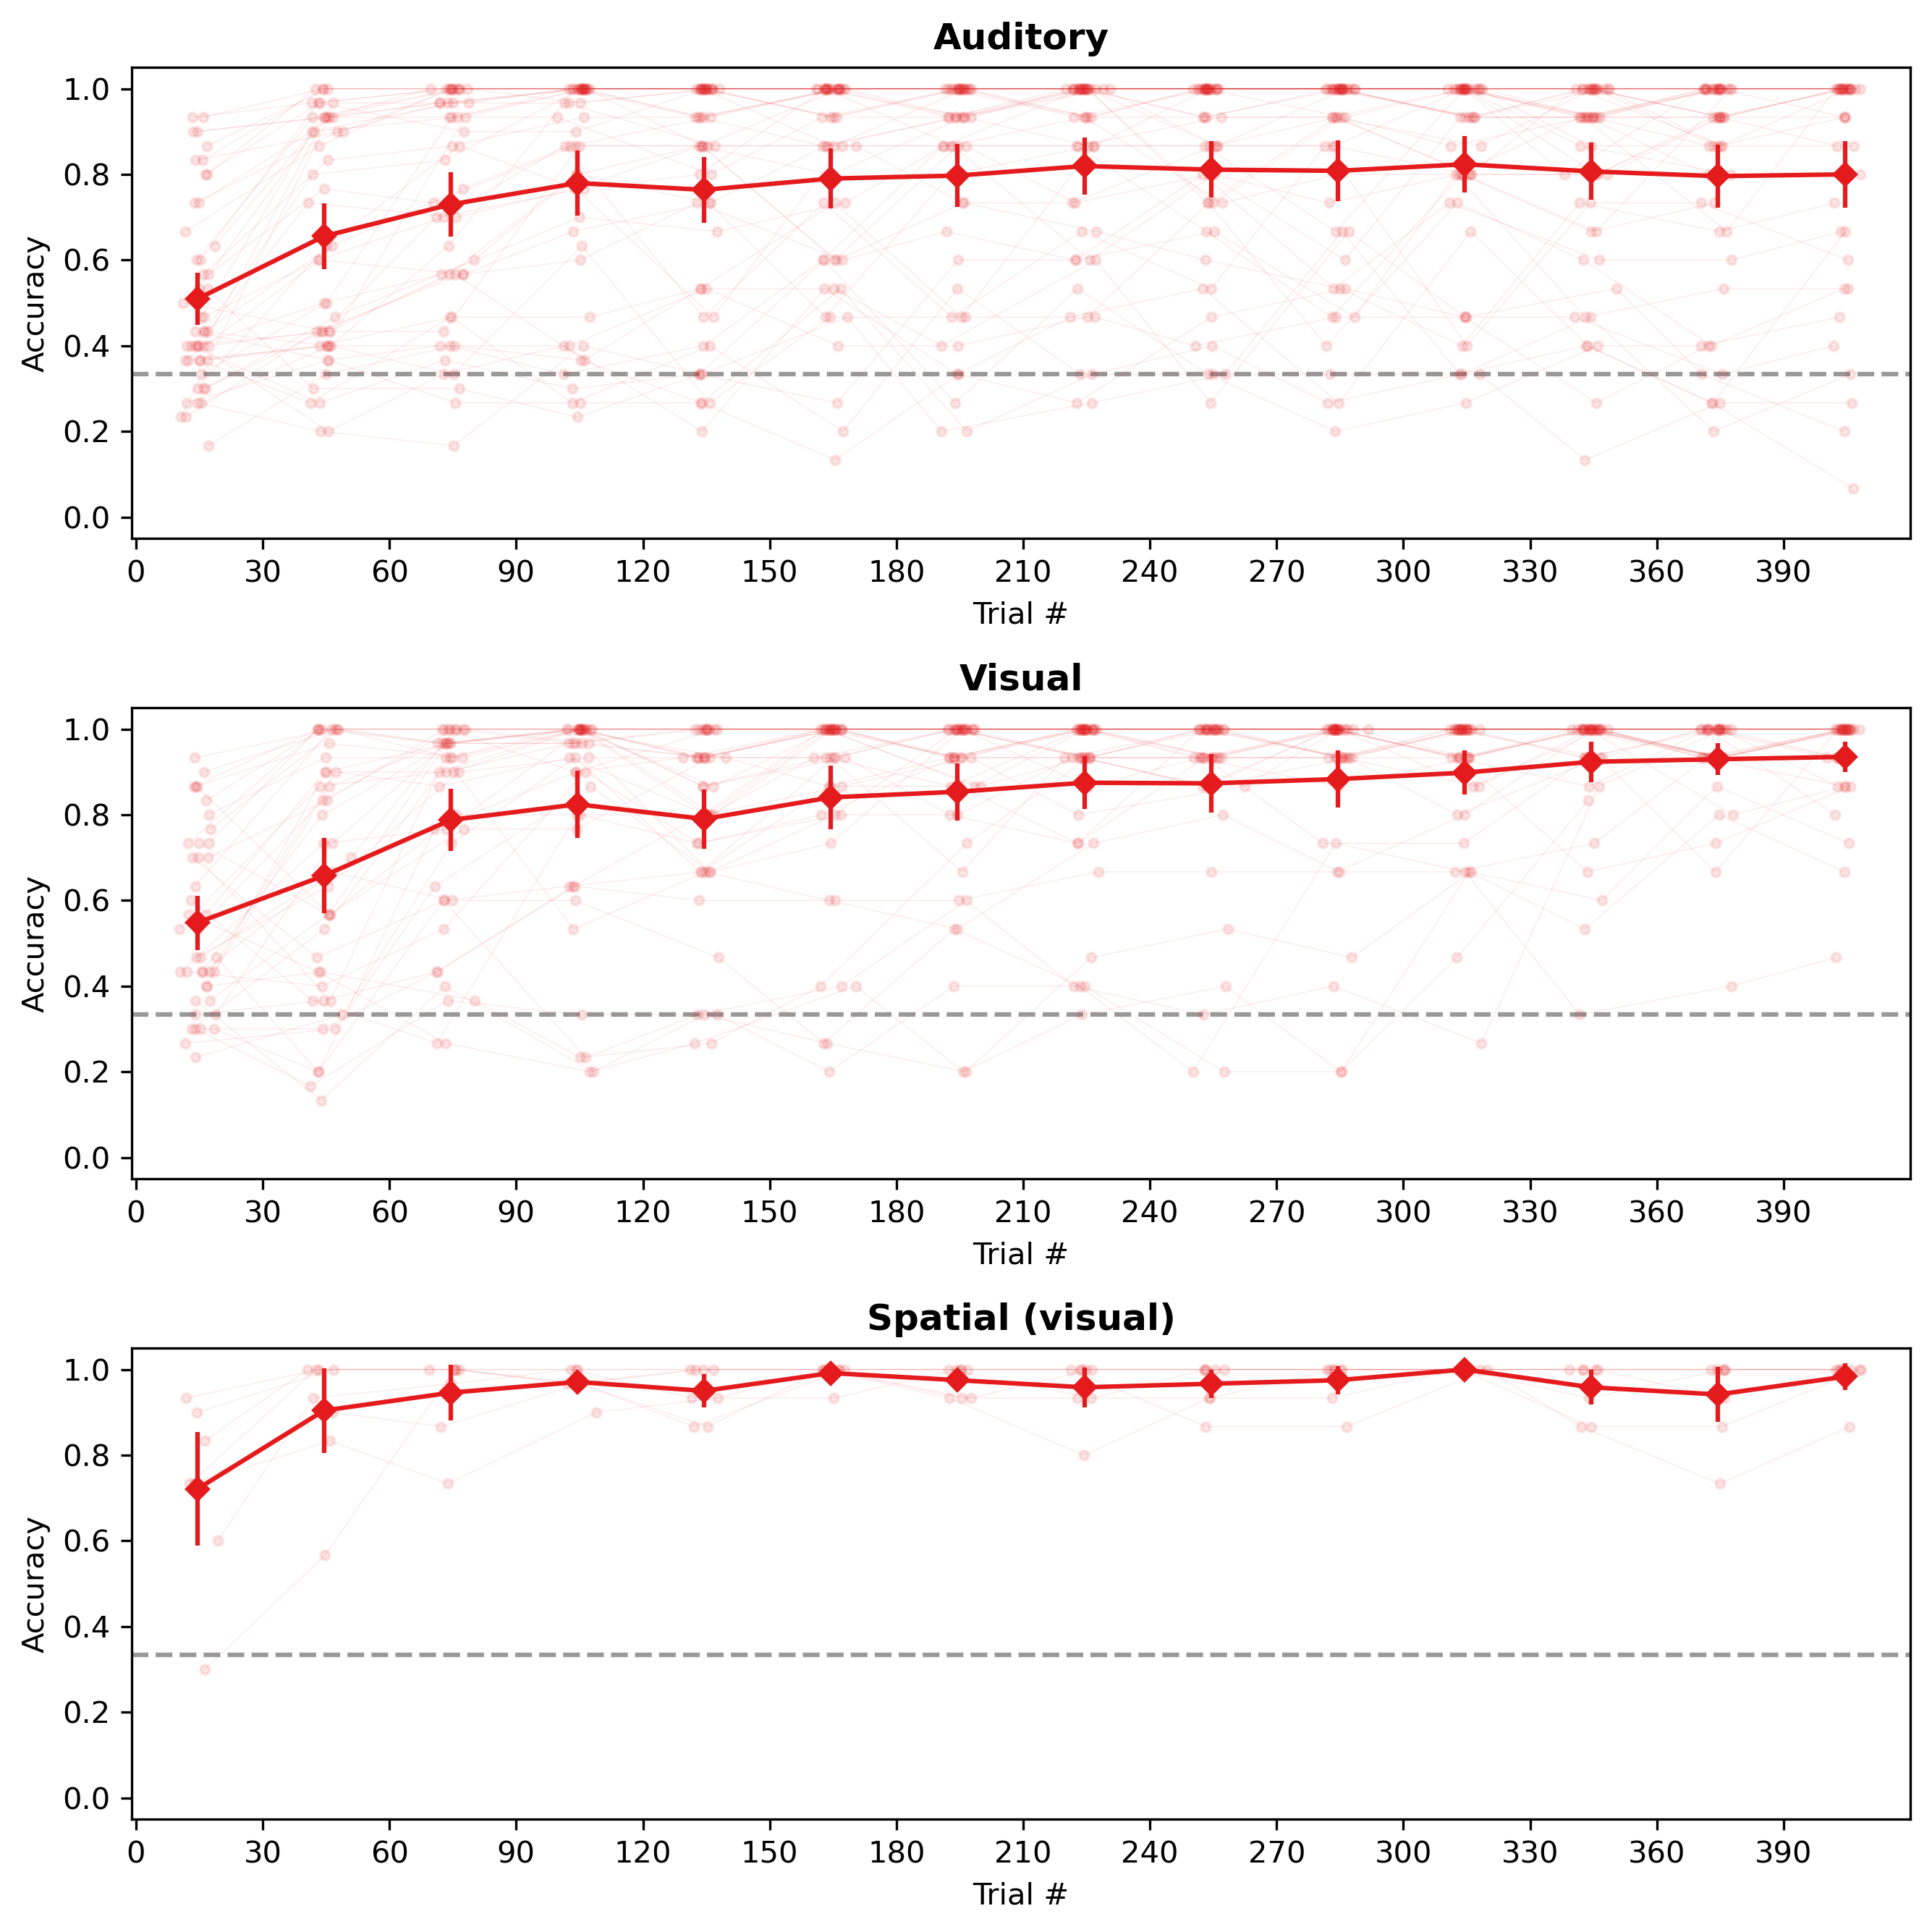

In [16]:
# Define figure
fig, axs = plt.subplots(n_modalities, 1, figsize=(9, 9), dpi=300, facecolor='w')

# Performance average across participants per bloc
for i, (ax, modality, modality_plot) in enumerate(zip(axs, modalities, modalities_plot)):
    
    # Get correct indexes
    center_idx = BLOC_CENTER_TRIAL[0, :]

    # Select subjects for this modality
    idx = MODALITY == modality
    
    # Compute average
    m_sujs = np.nanmean(CORRECT_BLOC_GEN[idx, :, 0], axis=-1)
    m = np.nanmean(m_sujs, axis=0)
    se = np.nanstd(m_sujs, axis=0)/np.sqrt(idx.sum())

    # Plot average
    ax.errorbar(
        x = center_idx, 
        y = m,
        yerr = 2 * se,
        color = bloc_type_colors['training'],
        markersize = 5,
        marker = 'D',
        alpha = 1 
    )

    # Plot individual data points
    for k in range(idx.sum()):
        ax.errorbar(
            x = center_idx + np.random.normal(0, 2, center_idx.size), 
            y = m_sujs[k],
            color = bloc_type_colors['training'],
            markersize = 3,
            marker = 'o',
            alpha = .1,
            lw = 0.3, # Do not plot the lines (this is messy)
        )

    # Aesthetics
    ax.set_title(modality_plot, fontweight='bold')
    ax.set_xlabel('Trial #')
    ax.set_ylabel('Accuracy')
    ax.set_xlim(-1, n_trials_per_suj)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xticks(BLOC_STARTING_TRIAL[0])
    ax.set_xticklabels(BLOC_STARTING_TRIAL[0])
    ax.axhline(1/3., color='k', ls='--', alpha=.4)

# Save figure
plt.tight_layout()
fig.savefig('figures/fig_1a.png')

/tmp/ipykernel_5414/2864378770.py:14: RuntimeWarning: Mean of empty slice
  m_sujs = np.nanmean(CORRECT_BLOC_GEN[idx, :, 0], axis=-1)
/tmp/ipykernel_5414/2864378770.py:14: RuntimeWarning: Mean of empty slice
  m_sujs = np.nanmean(CORRECT_BLOC_GEN[idx, :, 0], axis=-1)


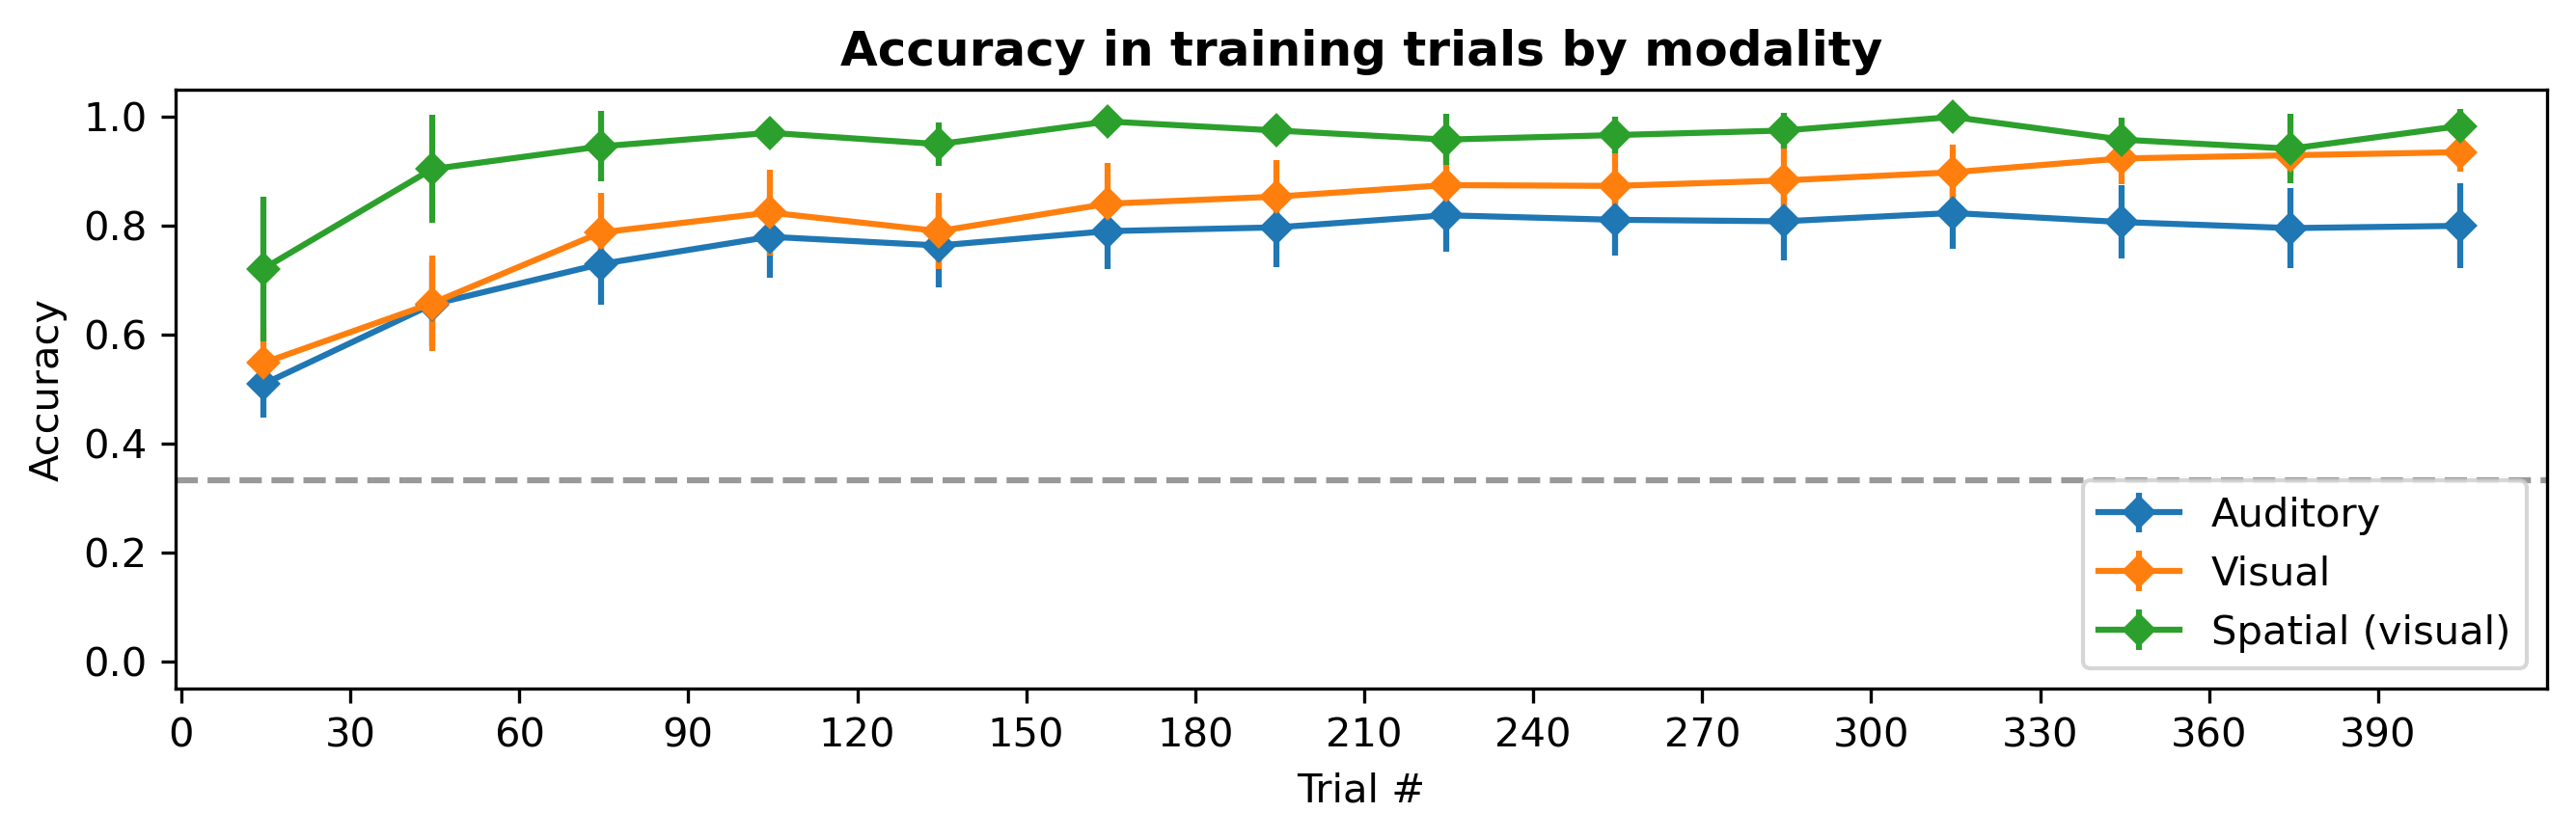

In [14]:
# Define figure
fig, ax = plt.subplots(1, 1, figsize=(9, 3), dpi=300, facecolor='w')

for i, (modality, modality_plot) in enumerate(zip(modalities, modalities_plot)):
    
    # Performance average per bloc
    # Get correct indexes
    center_idx = BLOC_CENTER_TRIAL[0, :]

    # Select subjects for this modality
    idx = MODALITY == modality
    
    # Compute average
    m_sujs = np.nanmean(CORRECT_BLOC_GEN[idx, :, 0], axis=-1)
    m = np.nanmean(m_sujs, axis=0)
    se = np.nanstd(m_sujs, axis=0)/np.sqrt(idx.sum())

    # Plot average
    ax.errorbar(
        x = center_idx, 
        y = m,
        yerr = 2 * se,
        #color = bloc_type_colors['training'],
        markersize = 5,
        marker = 'D',
        alpha = 1,
        label = modality_plot,
    )

# Aesthetics
ax.set_title('Accuracy in training trials by modality', fontweight='bold')
ax.set_xlabel('Trial #')
ax.set_ylabel('Accuracy')
ax.set_xlim(-1, n_trials_per_suj)
ax.set_ylim(-0.05, 1.05)
ax.set_xticks(BLOC_STARTING_TRIAL[0])
ax.set_xticklabels(BLOC_STARTING_TRIAL[0])
ax.axhline(1/3., color='k', ls='--', alpha=.4)
ax.legend(loc=4)

# Save figure
plt.tight_layout()
fig.savefig('figures/fig_1b.png')

# Figure 2 - Confusion matrix per generalization

In [15]:
trial_types = {
    64: r'$\emptyset$', 
    68: r'$|$',
    66: r'$—$',
    32: r'$| + —$',
    8:  r'$\curvearrowleft$',
    16: r'$\curvearrowright$',
    20: r'$\curvearrowright + |$',
    18: r'$\curvearrowright + —$',
    65: r'$\bigstar$',
    69: r'$\bigstar + |$',
    67: r'$\bigstar + —$',
}
n_trial_types = len(trial_types.keys())
n_trial_types

11

### Compute confusion matrices per generalization condition

In [16]:
labels = np.array(['zorro', 'butterfly', 'square'])
labels_names = np.array(['z', 'b', 's'])
n_labels = labels.size

In [17]:
CONFUSION_MATRIX_GEN = np.full((n_sujs, n_trial_types, n_labels, n_labels), np.nan)
for i in range(n_sujs):
    for j, trial_type in enumerate(trial_types.keys()):
        
        # Select data
        select = TRIAL_TYPE[i] == trial_type        
        y_true = CORRECT_CATEGORY_BLOC[i][select]
        y_pred = RESPONSE_CATEGORY_BLOC[i][select]
        CONFUSION_MATRIX_GEN[i, j] = confusion_matrix(y_true, y_pred, labels=labels, normalize='pred')

In [18]:
np.save(dname + 'CONFUSION_MATRIX_PARTICIPANTS', CONFUSION_MATRIX_GEN)

### Per generalization condition

In [19]:
# Prepare figure
fig, AXS = plt.subplots(n_sujs, n_trial_types, figsize=(9, 1*n_sujs), dpi=300, facecolor='w')
AXS = np.atleast_2d(AXS)

for i, (sujs, axs) in enumerate(zip(range(n_sujs), AXS)):
    for j, (ax, trial_type) in enumerate(zip(axs, trial_types.keys())):

        # Get colormap
        cmap = bloc_type_cmaps['training'] if trial_type == 64 else bloc_type_cmaps['generalization']
        if trial_type in (65, 67, 69): cmap = matplotlib.cm.get_cmap('Purples')

        # Compute confution matrix
        m = CONFUSION_MATRIX_GEN[i, j]

        # Add name of stimulus dimensions
        if j == 0:# or j == 8:
            for k in range(2):
                for l in range(2):
                    ax.text(
                        -.8 + l*0.7,
                        1.2 + k*0.2, 
                        str(DIMS[i, l, k]), 
                        size=5, 
                        transform=ax.transAxes, 
                        rotation=0,
                        horizontalalignment='center',
                        verticalalignment='center'
                    )

        # Plot matrix
        ax.imshow(m, vmin=0, vmax=1, cmap=cmap)
        ax.set_xticks(range(3))
        ax.set_yticks(range(3))
        ax.set_xticklabels(labels_names)
        ax.set_yticklabels(labels_names)
        ax.set_title(trial_types[trial_type], fontweight='bold')

plt.tight_layout()
fig.savefig('figures/fig_2.png')